In [1]:
import pandas
from pandas import DataFrame
import statsmodels
import matplotlib.pyplot as plt
import pylab as pl
import numpy

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score
from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV

In [2]:
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


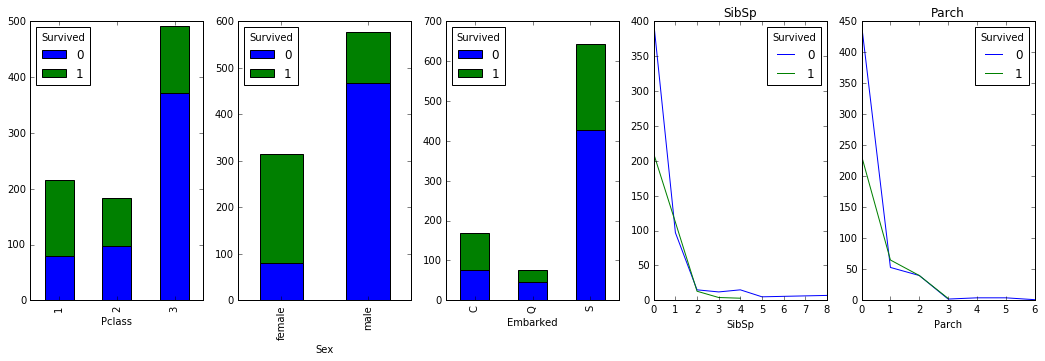

In [7]:
%matplotlib inline
fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(18, 5)
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(ax = axes[0], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(ax = axes[1], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(ax = axes[2], kind='bar', stacked=True)
train.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[3], title='SibSp')
train.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[4], title='Parch')

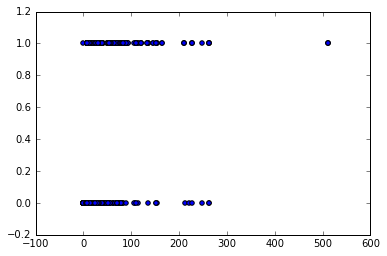

In [8]:
%matplotlib inline
plt.scatter(train['Fare'], train['Survived'])
plt.show()

In [2]:
#
# Preprocessing and scaling
#


train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")


def maxminscale(col_data, max_val, min_val):
    return (col_data - min_val) / (max_val - min_val)

def normalise(train, test, columns):
    for c in columns:
#         norm = MinMaxScaler()
#         norm.fit(numpy.concatenate([train[c], test[c]]))
        max_val, min_val = numpy.concatenate([train[c], test[c]]).max(), numpy.concatenate([train[c], test[c]]).min()
        train[c] = maxminscale(train[c], max_val, min_val)
        test[c] = maxminscale(test[c], max_val, min_val)


def replace_nan_age(data):
    data.loc[data.Age.isnull(), 'Age'] = data.Age.mean()


def replace_nan_fair(data):
    data.loc[data.Fare.isnull(), 'Fare'] = data.Fare.median()


def make_dummies(data):
    #return pandas.get_dummies(pandas.get_dummies(data, columns = ['Pclass', 'SibSp', 'Parch']))
    return pandas.get_dummies(pandas.get_dummies(data, columns = ['Pclass']))


def drop_columns(data):
    #to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
    return data.drop(to_drop, 1)


replace_nan_fair(train)
replace_nan_age(train)
train = make_dummies(drop_columns(train))

test_pid = test['PassengerId']

replace_nan_fair(test)
replace_nan_age(test)
test = make_dummies(drop_columns(test))

normalise(train, test, ['Fare', 'Age'])

print(train.columns)
print(test.columns)
train.describe()

Index(['Survived', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')
Index(['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male'],
      dtype='object')


,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.369900,0.062858,0.242424,0.206510,0.551066,0.352413,0.647587
std,0.486592,0.162871,0.096995,0.428790,0.405028,0.497665,0.477990,0.477990
min,0.000000,0.003132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.273456,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.369900,0.028213,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,0.436302,0.060508,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#
# Shuffling for Cross Validation
#


train_y = train['Survived']
train_X = train.drop('Survived', 1)

train_shuf = StratifiedShuffleSplit(train_y, n_iter = 10, test_size = .8, random_state = 123)

In [6]:
#
# Classifiers
#


clfs = [ensemble.RandomForestClassifier(), 
        linear_model.LogisticRegression(C = 1),
        svm.SVC(C = 10000)]

for clf in clfs:
    print(clf)
    score = cross_val_score(clf, train_X, train_y, cv=train_shuf)
    print(score, '\n=> ', score.mean(), ' (+-', score.std(),')\n', sep = '')


# LOGISTIC REGRESSION
# parameters = {'C': 10.**numpy.arange(-1, 1.2, .05), 'penalty': ['l2']}
# clf = linear_model.LogisticRegression()
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# best_logreg = gs.best_estimator_


# RANDOM FOREST
# parameters = {'n_estimators': [50, 130, 300, 500, 800, 1300, 2000], 
#               'max_features': numpy.arange(2, len(train_X.columns), 1),
#               'criterion': ['gini', 'entropy']
#              }
# clf = ensemble.RandomForestClassifier()
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# best_rf = gs.best_estimator_


# SVM
# parameters = {'kernel': ['linear'], 
#               'C': 10. ** numpy.arange(-1.8, -1.7, .001)
#              }
# clf = svm.SVC()
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("LINEAR")
# print(gs.best_score_)
# print(gs.best_estimator_)

# parameters = {'kernel': ['rbf'], 
#               'C': 10. ** numpy.arange(3, 3.4, .02),
#               'degree': [2],
#               'gamma': numpy.arange(.2, .3, .005)
#              }
# clf = svm.SVC()
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("RBF")
# print(gs.best_score_)
# print(gs.best_estimator_)

# parameters = {'kernel': ['poly'], 
#               'C': 10. ** numpy.arange(5, 6, .01),
#               'gamma': ['auto'],
#               'coef0': 10. ** numpy.arange(-5, 5, 1)
#              }
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("POLY")
# print(gs.best_score_)
# print(gs.best_estimator_)

# clf = svm.SVC()
# parameters = {'kernel': ['sigmoid'], 
#               'C': 10. ** numpy.arange(1.8, 2.5, .1),
#               'gamma': ['auto'],
#               'coef0': 10. ** numpy.arange(-5, 5, 1)
#              }
# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("SIGMOID")
# print(gs.best_score_)
# print(gs.best_estimator_)


# gs = GridSearchCV(clf, parameters, n_jobs = 4, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print(gs.best_score_)
# print(gs.best_estimator_)
# print(best_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[ 0.80224404  0.76437588  0.79943899  0.73632539  0.79803647  0.76297335
  0.78120617  0.78962132  0.75035063  0.76157083]
=> 0.77461430575 (+-0.0215920464233)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[ 0.78401122  0.77840112  0.79102384  0.80224404  0.77980365  0.76998597
  0.79242637  0.80084151  0.79523142  0.7769986 ]
=> 0.787096774194 (+-0.0103025905594)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0

In [31]:
#
# Writing the output
#

clf = gs.best_estimator_
# clf = clfs[-1]
print(clf)
clf.fit(train_X, train_y)

result = DataFrame()
clf.predict(test)
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", clf.predict(test))

result.to_csv("out.csv", index = False)

SVC(C=1737.8008287493763, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.21000000000000002,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [60]:
#
# Stacking
#


def stacking_model_predict(clf, train_X, train_y, test):
    clf.fit(train_X, train_y)
    return clf.predict_proba(test)


def insert_predictions(df, pred, colname):
    df.insert(len(df.columns), colname + ".0", pred[:,0])
    df.insert(len(df.columns), colname + ".1", pred[:,1])


# Best SVM
'''
SVC(C=1737.8008287493763, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.21000000000000002,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

'''
model_svm = svm.SVC(C=1737.8008287493763, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.21000000000000002,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


# Best LogReg
'''
LogisticRegression(C=0.22387211385683412, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
'''
model_logreg = linear_model.LogisticRegression(C=0.22387211385683412, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Best RF
'''
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
'''
model_rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


df = DataFrame()
insert_predictions(df, stacking_model_predict(model_svm, train_X, train_y, train_X), 'SVM')
insert_predictions(df, stacking_model_predict(model_logreg, train_X, train_y, train_X), 'LogReg')
insert_predictions(df, stacking_model_predict(model_rf, train_X, train_y, train_X), 'RF')
df.head()

,SVM.0,SVM.1,LogReg.0,LogReg.1,RF.0,RF.1
0,0.821547,0.178453,0.883326,0.116674,1.000000,0.000000
1,0.149290,0.850710,0.119722,0.880278,0.007692,0.992308
2,0.190175,0.809825,0.420532,0.579468,0.338462,0.661538
3,0.148603,0.851397,0.116845,0.883155,0.000000,1.000000
4,0.820435,0.179565,0.898487,0.101513,1.000000,0.000000


In [75]:
parameters = {'C': 10.**numpy.arange(-1.4, -.9, .0001), 'penalty': ['l1']}
stack_model = linear_model.LogisticRegression()
gs = GridSearchCV(stack_model, parameters, n_jobs = 4, cv = train_shuf)
gs = gs.fit(df, train_y)
print(gs.best_estimator_)
print(gs.best_score_)

LogisticRegression(C=0.10178880130153173, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.981767180926


In [76]:
#
# Writing the stacking output
#


df = DataFrame()
insert_predictions(df, stacking_model_predict(model_svm, train_X, train_y, test), 'SVM')
insert_predictions(df, stacking_model_predict(model_logreg, train_X, train_y, test), 'LogReg')
insert_predictions(df, stacking_model_predict(model_rf, train_X, train_y, test), 'RF')

clf = gs.best_estimator_
print(clf)

result = DataFrame()
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", clf.predict(df))

result.to_csv("out_stacking.csv", index = False)

LogisticRegression(C=0.10178880130153173, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [73]:
len(10.**numpy.arange(-2, 0, .0005) - 0.13899526312129504)

4000